In [ ]:
pip install JPype1 zemberek-python

In [ ]:
pip install transformers

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zemberek import TurkishMorphology

In [ ]:
# Zemberek kütüphanesi ile yazım düzeltme
morphology = TurkishMorphology.create_with_defaults()

def correct_spelling(sentence):
    analysis = morphology.analyze_and_disambiguate(sentence).best_analysis()
    corrected_sentence = " ".join([str(a.surface_form) for a in analysis])
    return corrected_sentence

# Hugging Face modelini yükleyin
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")

# Sentetik metin üretme fonksiyonu
def generate_text(prompt, num_samples=10, max_length=50, temperature=0.7, top_k=50, top_p=0.9):
    generated_texts = []
    for _ in range(num_samples):
        input_ids = tokenizer.encode(prompt, return_tensors="pt")
        output = model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p
        )
        generated_texts.append(tokenizer.decode(output[0], skip_special_tokens=True))
    return generated_texts

# Veri setini yükle
file_path = '/content/Türkçe Nefret Söylemi Veri Seti v1_1.xlsx'  # Dosyanızın tam yolunu buraya yazın
raw_data = pd.ExcelFile(file_path)
combined_data = pd.DataFrame()

for sheet_name in raw_data.sheet_names:
    if sheet_name != 'TOPLAM':
        sheet = raw_data.parse(sheet_name)
        if 'Tweet' in sheet.columns and 'Etiket' in sheet.columns:
            combined_data = pd.concat([combined_data, sheet[['Tweet', 'Etiket']]], ignore_index=True)

# Yazım düzeltme işlemi
combined_data['Tweet'] = combined_data['Tweet'].apply(correct_spelling)


In [ ]:
# Sınıf dağılımını kontrol et
class_counts = combined_data['Etiket'].value_counts()
print("Original class distribution:")
print(class_counts)


In [ ]:
# Hedef sayıyı belirleyin
TARGET_COUNT = 1000

# Dengeli veri seti oluşturma
balanced_data = pd.DataFrame()
synthetic_data = []

for label in class_counts.index:
    current_count = class_counts[label]
    label_data = combined_data[combined_data['Etiket'] == label]

    if current_count < TARGET_COUNT:
        prompt = f"{label} sınıfına ait bir tweet"
        num_samples = TARGET_COUNT - current_count
        synthetic_tweets = generate_text(prompt, num_samples=num_samples)
        synthetic_data = pd.DataFrame([{'Tweet': tweet, 'Etiket': label} for tweet in synthetic_tweets])
        label_data = pd.concat([label_data, synthetic_data], ignore_index=True)
    elif current_count > TARGET_COUNT:
        label_data = label_data.sample(TARGET_COUNT, random_state=42)

    balanced_data = pd.concat([balanced_data, label_data], ignore_index=True)

In [35]:
# Yeni sınıf dağılımını kontrol et
print("Balanced class distribution:")
print(balanced_data['Etiket'].value_counts())


Balanced class distribution:
Etiket
hiçbiri      1000
nefret       1000
saldırgan    1000
Name: count, dtype: int64


In [ ]:
# Özellikler ve etiketler
X = balanced_data['Tweet']
y = balanced_data['Etiket']

# Etiketleri sayısal değerlere dönüştür
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Daha büyük bir veri setiyle cümleleri hazırlayın
sentences = [tweet.split() for tweet in X]

# Word2Vec modelini oluşturma ve hiperparametreleri ayarlama
word2vec_model = Word2Vec(
    sentences=sentences,
    vector_size=200,  # Daha yüksek boyutlu vektörler
    window=10,        # Daha geniş bağlam penceresi
    min_count=3,      # Daha az görülen kelimeleri dışlama
    workers=4,        # Paralel iş parçacıkları
    sg=1              # Skip-gram modeli
)

# Metinleri Word2Vec vektörlerine dönüştürme
def vectorize_tweet(tweet):
    words = tweet.split()
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(200)

X_vectorized = np.array([vectorize_tweet(tweet) for tweet in X])

# Eğitim ve test verisi bölme
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Karar eşiği ile tahmin fonksiyonu
def predict_with_threshold(model, X_test, threshold=0.5, is_ann=False):
    if is_ann:
        probabilities = model.predict(X_test)
    else:
        probabilities = model.predict_proba(X_test)
    predictions = (probabilities[:, 1] >= threshold).astype(int) if not is_ann else np.argmax(probabilities, axis=1)
    return predictions

# Sınıflandırıcılar
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine (SVM)': SVC(kernel='linear', probability=True, random_state=42),
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Sonuçları saklama
performance_table = []

Training Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

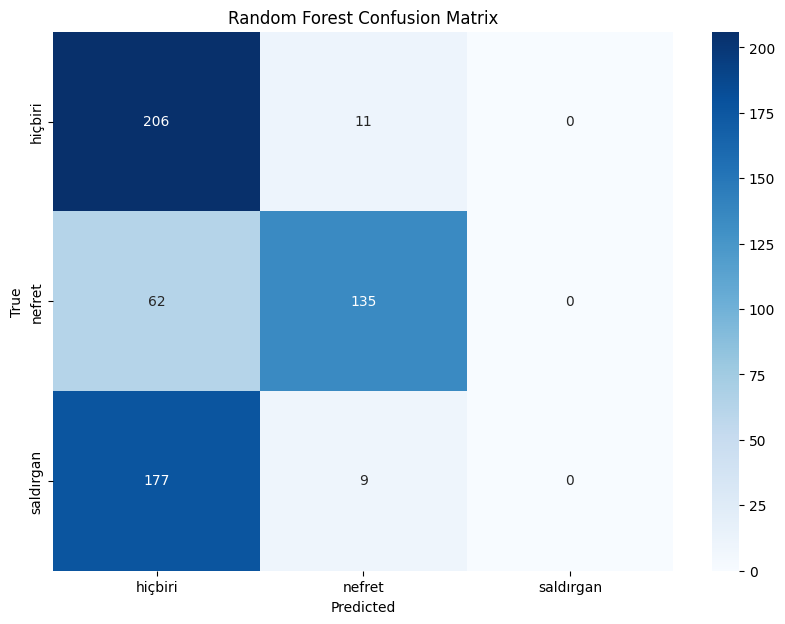

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warni

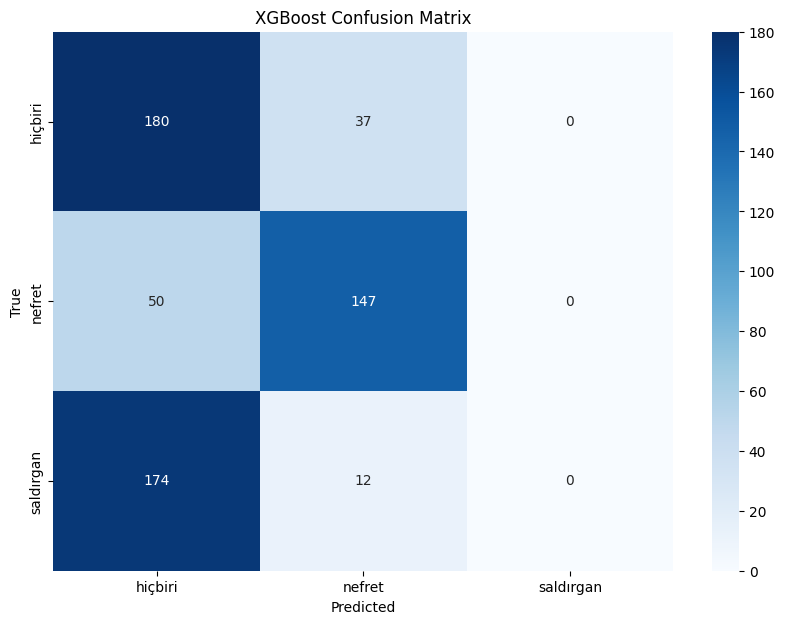

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47892
[LightGBM] [Info] Number of data points in the train set: 2442, number of used features: 200
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warn

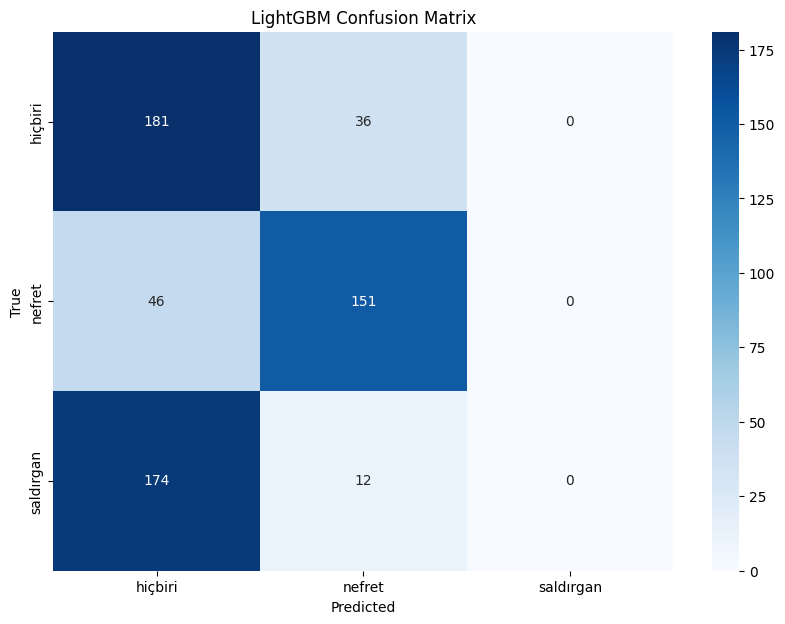

Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

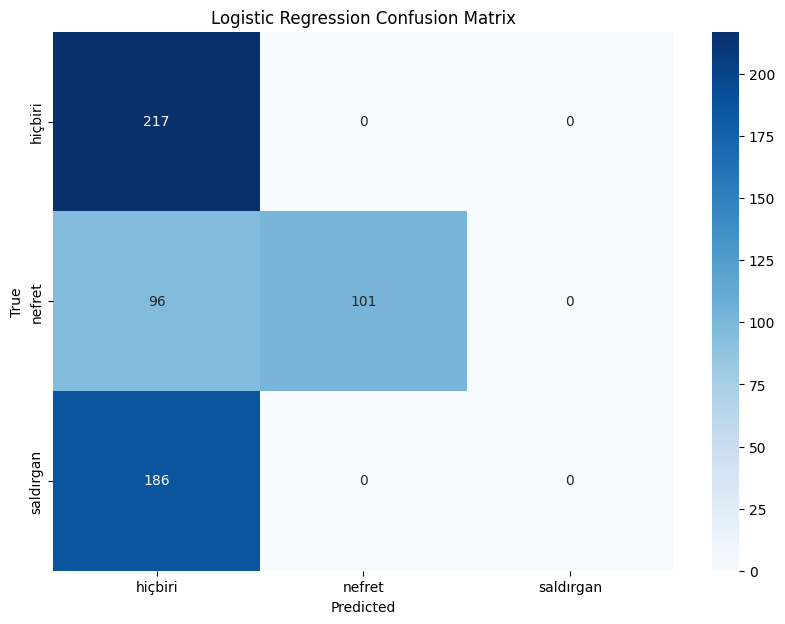

Training Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

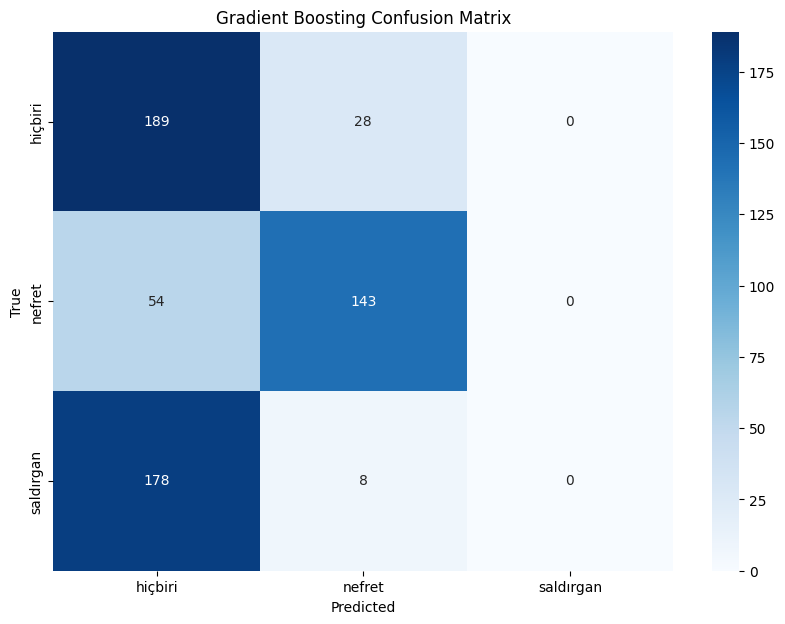

Training Support Vector Machine (SVM)...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

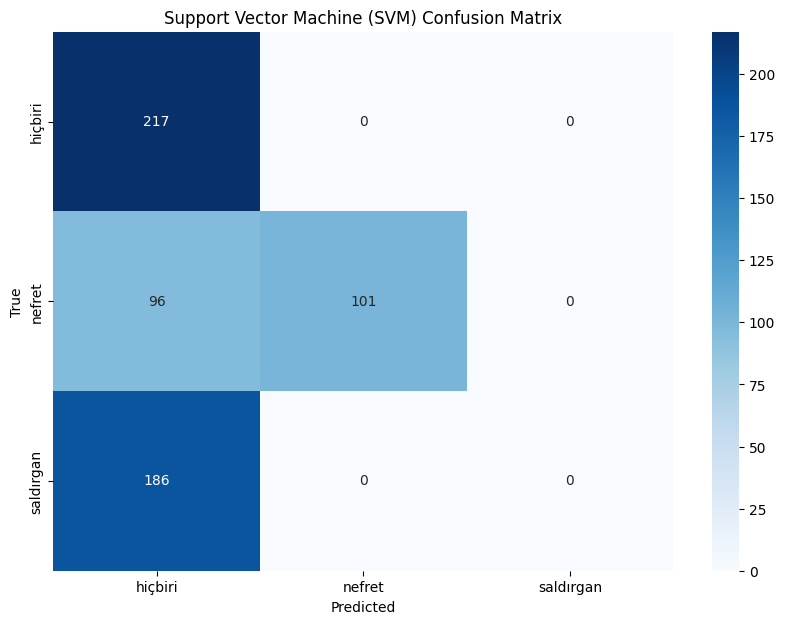

Training k-Nearest Neighbors...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

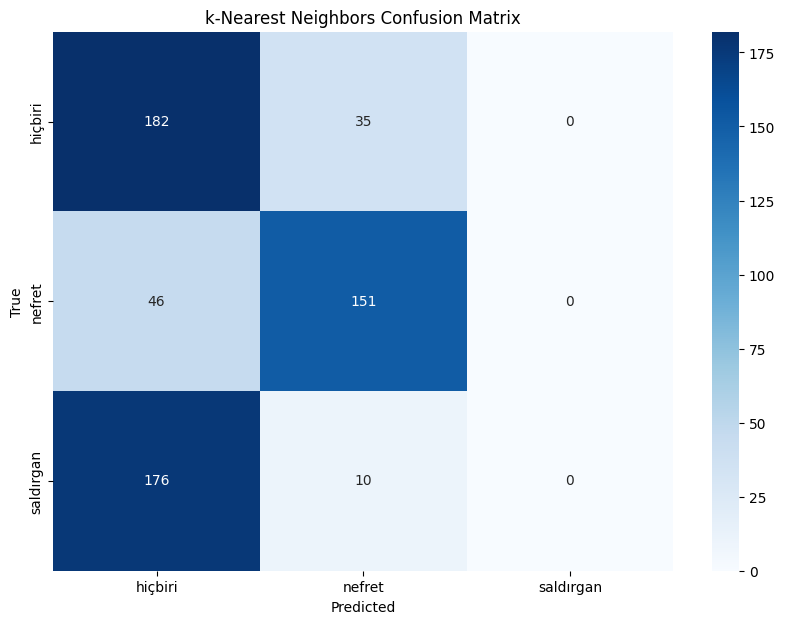

In [37]:
# Tüm modelleri döngüyle çalıştır ve performanslarını değerlendir
best_accuracy = 0
best_model_name = None
best_model = None

for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")

    # SMOTE ile sınıf dengesizliğini gider
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Modeli eğit ve tahmin yap
    clf.fit(X_train_smote, y_train_smote)
    y_pred = predict_with_threshold(clf, X_test, threshold=0.5)

    # Performansı değerlendirin
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = clf_name
        best_model = clf

    # Performans sonuçlarını tabloya ekle
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            performance_table.append({
                'Classifier': clf_name,
                'Class': label_encoder.inverse_transform([int(label)])[0] if label.isdigit() else label,
                'Precision': metrics.get('precision', 0),
                'Recall': metrics.get('recall', 0),
                'F1-Score': metrics.get('f1-score', 0),
                'Accuracy': accuracy
            })

    # Confusion Matrix Görselleştirme
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"{clf_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [ ]:
from imblearn.combine import SMOTETomek

# Kombinasyon yöntemi (SMOTE + Tomek Links) ile veri dengesizliğini giderme
smote_tomek = SMOTETomek(random_state=42)
X_train_combined, y_train_combined = smote_tomek.fit_resample(X_train, y_train)

# ANN Modelini geliştirme ve eğitme
ann_model = Sequential()
ann_model.add(Dense(256, input_dim=X_train_combined.shape[1], activation='relu'))  # Daha fazla nöron
ann_model.add(Dropout(0.3))  # Overfitting'i önlemek için daha fazla dropout
ann_model.add(Dense(128, activation='relu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(len(label_encoder.classes_), activation='softmax'))
ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Kategorik hale getirilmiş verilerle eğitme
y_train_ann_combined = to_categorical(y_train_combined, num_classes=len(label_encoder.classes_))
y_test_ann = to_categorical(y_test, num_classes=len(label_encoder.classes_))

ann_model.fit(X_train_combined, y_train_ann_combined, epochs=20, batch_size=32, validation_data=(X_test, y_test_ann), verbose=1)

# ANN Performans değerlendirme
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
accuracy_ann = accuracy_score(y_test, y_pred_ann)

# Performansı tabloya ekle
performance_table.append({
    'Classifier': 'Artificial Neural Network (ANN) + SMOTE+Tomek Links',
    'Class': 'Overall',
    'Precision': None,
    'Recall': None,
    'F1-Score': None,
    'Accuracy': accuracy_ann
})

# Performansı CSV'ye kaydetme
performance_df = pd.DataFrame(performance_table)
csv_file_path = "performance_results.csv"
performance_df.to_csv(csv_file_path, index=False, encoding='utf-8-sig')
print(f"Performans sonuçları {csv_file_path} dosyasına kaydedildi.")

In [46]:
# Kullanıcıdan tweet al ve tahmin yap
def predict_tweet(tweet, model, is_ann=False):
    vec_tweet = vectorize_tweet(correct_spelling(tweet)).reshape(1, -1)
    if is_ann:
        prediction = np.argmax(model.predict(vec_tweet), axis=1)
    else:
        prediction = model.predict(vec_tweet)
    return label_encoder.inverse_transform([prediction[0]])[0]

# Kullanıcıdan bir tweet alarak tahmin yapma
print("\nModel hazır! Bir tweet girerek tahmin yapabilirsiniz.")
user_tweet = input("Bir tweet giriniz: ")

# En iyi model ile tahmin yapma
if best_model_name != "Artificial Neural Network (ANN)":
    print(f"Girilen tweetin tahmini etiketi (En İyi Model - {best_model_name}): {predict_tweet(user_tweet, best_model)}")
else:
    print(f"Girilen tweetin tahmini etiketi (En İyi Model - {best_model_name}): {predict_tweet(user_tweet, best_model, is_ann=True)}")

# ANN ile tahmin yapma
print(f"Girilen tweetin tahmini etiketi (ANN): {predict_tweet(user_tweet, ann_model, is_ann=True)}")

# Random Forest ile tahmin yap
random_forest_model = classifiers['Random Forest']
print(f"Girilen tweetin tahmini etiketi (Random Forest): {predict_tweet(user_tweet, random_forest_model)}")



Model hazır! Bir tweet girerek tahmin yapabilirsiniz.
Bir tweet giriniz: Yeter artık bu yaşadıklarımız sürekli sorun çıkmasından sorunlar yaşamaktan çok amam çok sıkıldım
Girilen tweetin tahmini etiketi (En İyi Model - Random Forest): nefret
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Girilen tweetin tahmini etiketi (ANN): hiçbiri
Girilen tweetin tahmini etiketi (Random Forest): nefret
